In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import vizdoom
import os
import time
import random
import numpy as np
from collections import deque
from skimage import transform
from IPython.display import display, clear_output
import tensorflow as tf

c:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class Scheduler():
    def __init__(self, initial_value, interval, decay_factor):
        self.interval = self.counter = interval
        self.decay_factor = decay_factor
        self.value_factor = 1
        self.value = initial_value
        
    def get_value(self):
        self.counter -= 1
        if self.counter < 0:
            self.counter = self.interval
            self.value *= self.decay_factor
        return self.value
        
lr_scheduler = Scheduler(initial_value=1e-4, interval=10, decay_factor=0.95)

In [3]:
class DoomEnv():
    def __init__(self, show_window=False):
        # Setup DoomGame
        self.game = vizdoom.DoomGame()
        #self.game.load_config("doom/my_way_home.cfg")
        #self.game.load_config("doom/defend_the_center.cfg")
        self.game.load_config("doom/basic.cfg")

        # Visualize the game (set to False to train faster)
        self.game.set_window_visible(show_window)

        # Set screen format to greyscale, improves training time
        self.game.set_screen_format(vizdoom.ScreenFormat.GRAY8)

        # Make the game end after 2100 ticks (set to 0 to disable)
        #self.game.set_episode_timeout(2100)

        # Init game
        self.game.init()
        
    def reset(self):
        self.game.new_episode()
        
        # Setup initial state
        self.frame_stack = deque(maxlen=frame_stack_size)
        initial_frame = preprocess_frame(self.game.get_state().screen_buffer)
        for _ in range(frame_stack_size):
            self.frame_stack.append(initial_frame)
        self.state = np.stack(self.frame_stack, axis=2)
        
        self.total_reward = 0
        
num_envs = 16
envs = [DoomEnv(i == 0) for i in range(num_envs)]

In [4]:
discount_factor  = 0.99
num_actions      = envs[0].game.get_available_buttons_size()
save_interval    = 100
t_max            = 5
frame_stack_size = 4

In [5]:
def entropy(logits):
    a0 = logits - tf.reduce_max(logits, axis=-1, keepdims=True)
    ea0 = tf.exp(a0)
    z0 = tf.reduce_sum(ea0, axis=-1, keepdims=True)
    p0 = ea0 / z0
    return tf.reduce_sum(p0 * (tf.log(z0) - a0), axis=-1)

class A2C():
    def __init__(self, num_actions, optimizer, value_scale=0.5, entropy_scale=0.01, model_checkpoint=None):
        tf.reset_default_graph()
        
        # Construct model
        self.input_states = tf.placeholder(shape=(None, 84, 84, 4), dtype=tf.float32)
        self.conv1 = tf.keras.layers.Conv2D(16, (5, 5), activation="relu", padding="valid")(self.input_states)
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(self.conv1)
        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="valid")(self.pool1)
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(self.conv2)
        self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="valid")(self.pool2)
        self.shared_features = tf.keras.layers.Flatten()(self.conv3)
        
        # Policy branch
        self.action_logits = tf.keras.layers.Dense(num_actions, activation=None)(self.shared_features)
        self.action_prob   = tf.keras.layers.Softmax()(self.action_logits)
        
        # Baseline value branch
        self.value  = tf.keras.layers.Dense(1, activation=None)(self.shared_features) # V(s_t; θ_v)
        
        # Create policy gradient train function
        self.actions_placeholder = tf.placeholder(shape=(None,), dtype=tf.int32)
        self.returns_placeholder = tf.placeholder(shape=(None,), dtype=tf.float32)
        self.values_placeholder  = tf.placeholder(shape=(None,), dtype=tf.float32)
        self.lr_placeholder      = tf.placeholder(shape=(), dtype=tf.float32)
        
        # Get probabilities of taken actions: log π(a_t | s_t; θ)
        # log_action_prob = tf.log(tf.reduce_sum(self.action_prob * self.actions_onehot_placeholder, axis=1))
        self.neg_log_action = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.action_logits,
                                                                             labels=self.actions_placeholder)
        
        # Policy Gradient Loss = ∇_θ log π(a_t | s_t; θ)(R_t − V(s_t; θ_v))
        # Negative log likelihood of the taken actions, weighted by the discounted and normalized rewards
        # self.policy_loss = -tf.reduce_mean(log_action_prob * (self.returns_placeholder - self.value))
        self.policy_loss  = tf.reduce_mean((self.returns_placeholder - self.values_placeholder) * self.neg_log_action)
        
        # Get value loss
        # MSE(V(s_t), R_t)
        self.value_loss = tf.reduce_mean(tf.squared_difference(tf.squeeze(self.value), self.returns_placeholder))
        
        # Get entropy
        # self.entropy_loss = -tf.reduce_mean(self.action_prob * tf.log(self.action_prob + 0.0001))
        self.entropy_loss = tf.reduce_mean(entropy(self.action_logits))
        
        # Total loss
        self.loss = self.policy_loss + self.value_loss * value_scale - self.entropy_loss * entropy_scale
        
        # Minimize loss
        self.optimizer = optimizer(learning_rate=self.lr_placeholder, decay=0.99)
        self.learning_rate = 1e-4
        self.train_step = self.optimizer.minimize(self.loss)
        
        # Create session
        self.sess = tf.Session()

        # Run the initializer
        self.sess.run(tf.global_variables_initializer())
        
        tf.summary.scalar("policy_loss", self.policy_loss)
        tf.summary.scalar("value_loss", self.value_loss)
        tf.summary.scalar("entropy_loss", self.entropy_loss)
        tf.summary.scalar("loss", self.loss)
        tf.summary.scalar("learning_rate", self.lr_placeholder)
        self.summary_merged = tf.summary.merge_all()
        
        # Load model checkpoint if provided
        self.saver = tf.train.Saver()
        if model_checkpoint:
            self.run_idx = int(re.findall(r"_run\d+", model_checkpoint)[0][len("_run"):])
            self.step_idx = int(re.findall(r"_step\d+", model_checkpoint)[0][len("_step"):])
            self.saver.restore(self.sess, model_checkpoint)
            print("Model checkpoint restored from {}".format(model_checkpoint))
        else:
            self.run_idx = 0
            while os.path.isdir("./logs/run{}".format(self.run_idx)):
                self.run_idx += 1
            self.step_idx = 0
        self.train_writer = tf.summary.FileWriter("./logs/run{}".format(self.run_idx), self.sess.graph)
        
        
    def save(self):
        model_checkpoint = "./models/a2c_run{}_step{}.ckpt".format(self.run_idx, self.step_idx)
        self.saver.save(self.sess, model_checkpoint)
        print("Model checkpoint saved to {}".format(model_checkpoint))
        
    def train(self, input_states, actions, returns, values):
        r = self.sess.run([self.summary_merged, self.train_step, self.loss, self.policy_loss, self.value_loss, self.entropy_loss],
                          feed_dict={self.input_states: input_states,
                                     self.actions_placeholder: actions,
                                     self.returns_placeholder: returns,
                                     self.values_placeholder: values,
                                     self.lr_placeholder: self.learning_rate})
        self.train_writer.add_summary(r[0], self.step_idx)
        self.step_idx += 1
        return r[2:]
        
    def predict(self, input_states):
        return self.sess.run([self.action_prob, self.value], feed_dict={self.input_states: input_states})
    
a2c_model = A2C(num_actions=num_actions, optimizer=tf.train.RMSPropOptimizer)

-- Episode 1201 --
Learning rate: 3.7314100463728023e-07
Episode policy loss: -0.011631995148491114
Episode value loss: 0.0030090386972005945
Episode entropy loss: 23.818559050559998
Episode loss: -0.2483130618929863
Average episode reward: 0.05424999999999995



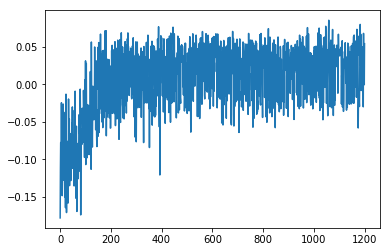

Resetting envronments...
Training...


KeyboardInterrupt: 

In [6]:
def preprocess_frame(frame):
    cropped_frame = frame[30:-10, 30:-30] # Crop the screen
    normalized_frame = cropped_frame / 255.0 # Normalize Pixel Values
    preprocessed_frame = transform.resize(normalized_frame, [84, 84]) # Resize
    return preprocessed_frame

def calculate_expected_return(rewards, gamma):
    expected_return = []
    r = 0
    for reward in rewards[::-1]: # for rewards from end to start
        r = reward + gamma * r
        expected_return.append(r)
    return expected_return[::-1] # reverse so that we get the expected return from start to end

average_episode_rewards = []
#for episode in range(num_episodes):
episode = 0
while True:
    print("Resetting envronments...")
    episode += 1
    for env in envs:
        env.reset()
    
    # While there are running environments
    print("Training...")
    a2c_model.learning_rate = lr_scheduler.get_value()
    episode_loss = episode_policy_loss = episode_value_loss = episode_entropy_loss = 0
    average_episode_reward = []
    while sum([env.game.is_episode_finished() for env in envs]) < num_envs:
        states, actions, returns, values = [], [], [], []
        
        # For every environment
        for env in envs:
            # Simulate game for some number of steps
            rewards = []
            for _ in range(t_max):
                # Predict and value action given state
                # π(a_t | s_t; θ)
                action_prob, value = a2c_model.predict(np.expand_dims(env.state, axis=0))
                action_prob, value = np.squeeze(action_prob), np.squeeze(value)
                
                # Take action stochastically 
                action = np.random.choice(np.arange(0, num_actions), p=action_prob)
                action_one_hot = [False] * num_actions
                action_one_hot[action] = True
                reward = env.game.make_action(action_one_hot) * 0.001
                
                # Store state, action and reward
                states.append(env.state)
                actions.append(action)
                rewards.append(reward)
                values.append(value)
                env.total_reward += reward

                if env.game.is_episode_finished():
                    break
                    
                # Get new state
                env.frame_stack.append(preprocess_frame(env.game.get_state().screen_buffer))
                env.state = np.stack(env.frame_stack, axis=2)
                
            # Calculate return (discounted rewards over a trajectory)
            last_value = 0 if env.game.is_episode_finished() else \
                         a2c_model.predict(np.expand_dims(env.state, axis=0))[1][0][0]
            returns.extend(calculate_expected_return(rewards+[last_value], discount_factor)[:-1])
            average_episode_reward.extend(rewards)
            
        eploss, pgloss, vloss, entloss = a2c_model.train(states, actions, returns, values)
        episode_loss         += eploss
        episode_policy_loss  += pgloss
        episode_value_loss   += vloss
        episode_entropy_loss += entloss
    average_episode_rewards.append(sum([env.total_reward for env in envs]) / len(envs))
    
    clear_output(wait=True)
    print("-- Episode {} --".format(episode))
    print("Learning rate:", a2c_model.learning_rate)
    print("Episode policy loss:", episode_policy_loss)
    print("Episode value loss:", episode_value_loss)
    print("Episode entropy loss:", episode_entropy_loss)
    print("Episode loss:", episode_loss)
    print("Average episode reward:", average_episode_rewards[-1])
    print("")
    plt.plot(np.arange(0, len(average_episode_rewards)), average_episode_rewards)
    plt.show()
    
    if episode % save_interval == 0:
        a2c_model.save()

print("Done!")

In [7]:
import time
env = DoomEnv(True)
greedy = True
for episode in range(10):
    env.reset()
    while not env.game.is_episode_finished():
        # Predict action given state: π(a_t | s_t; θ)
        action_prob = np.squeeze(a2c_model.predict(np.expand_dims(env.state, axis=0))[0])
        if greedy:
            action = np.argmax(action_prob)
        else:
            action = np.random.choice(np.arange(0, num_actions), p=action_prob) # Sample action stochastically
        action_one_hot = [False] * num_actions
        action_one_hot[action] = True

        # Take the action
        env.game.make_action(action_one_hot)
        time.sleep(0.016)
        
        if not env.game.is_episode_finished():
            # Get new state
            env.frame_stack.append(preprocess_frame(env.game.get_state().screen_buffer))
            env.state = np.stack(env.frame_stack, axis=2)